# Import libraries

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [15]:
driveURL = r'/content/drive/MyDrive/Neural'

----

# Read `Info.txt` file

This file has labeled image names

In [16]:
# Read the text file with space(' ') as the delimitter
df = pd.read_csv(driveURL + '/' + 'Info.txt', sep = ' ')

In [ ]:
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,Unnamed: 7
0,mdb001,G,CIRC,B,535.0,425.0,197.0,NaN
1,mdb002,G,CIRC,B,522.0,280.0,69.0,NaN
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0,NaN


-----

# Clean the DataFrame

In [ ]:
# Select useful('IMAGE' and 'SEVERITY') columns
df['IMAGE'] = df['REFNUM']
df = df[['IMAGE', 'SEVERITY']]

# Fill NA values i.e. images having no growth with 'N'(Normal)
df['SEVERITY'].fillna('N', inplace = True)

# Drop duplicates if any
df.drop_duplicates(subset = 'IMAGE',inplace = True)

# Reset the index
df.set_index(np.arange(len(df)), inplace = True)

df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,IMAGE,SEVERITY
0,mdb001,B
1,mdb002,B
2,mdb003,N
3,mdb004,N
4,mdb005,B


-----

# Analyse the DataFrame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE     322 non-null    object
 1   SEVERITY  322 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


#### Classes of Severity

- Benign: Non cancerous
- Malignant: Cancerous
- No growth

In [ ]:
classes = df.groupby('SEVERITY').count()

# Change the index
index = pd.Series(classes.index)
index = index.map({'B': 'Benign growth', 'M': 'Malignant growth', 'N': 'No growth'})

# Reassign the index
classes.index = index.values

# Reassign the column
col = list(classes.columns)
col[0] = 'Number of images'
classes.columns = col

classes

,Number of images
Benign growth,64
Malignant growth,51
No growth,207


---
# Save the DataFrame

In [ ]:
# Do not save the index
df.to_csv(driveURL + '/' + 'newInfo.txt', sep = ' ', index = False)

---

# Change the image format

- Raw image format is `.pgm` which takes a lot of space
- Convert it to `.jpg` which takes a lot less space

In [18]:
# Directory with raw .pgm images
img_dir = driveURL + '/' + 'all-mias'

# Image names with extension
img_name = np.array(os.listdir(img_dir))

# Final image address
img_add = np.char.add(img_dir + '/', img_name)

# Directory which will have .jpg images
outDir = driveURL + '/' + 'all-mias-jpg'

# Function to convert .pgm image to .jpg image
def PNG_to_JPG(img, img_add, outDir):
    new_file = f'{img}.jpg'
    with Image.open(img_add) as im:
        im.save(outDir + '/' + new_file)

total_images = len(img_name)

# Iterate over all images
for i in range(total_images):
    # Image name
    img = img_name[i]
    
    # Image name without extension
    img_no_extension = img[:len(img) - 4]
    PNG_to_JPG(img_no_extension, img_add[i], outDir)

#### Folder size comparison

In [19]:
# Function to compute size of the folder
def folderSize(folder):
    size = 0
    for file in os.scandir(folder):
        size += os.stat(file).st_size
        
    return np.round(size / 1e6, 2)

print(f'Size of images in .pgm format: {folderSize(img_dir)} MB')
print(f'Size of images in .jpg format: {folderSize(outDir)} MB')

# Change the image address to the new folder
img_name = np.array(os.listdir(outDir))
img_add = np.char.add(outDir + '/', img_name)

Size of images in .pgm format: 337.65 MB
Size of images in .jpg format: 12.1 MB


----

# Function to plot images

In [20]:
# Function to plot the image, remove the axes and give a title
# This will be called throughout the code
def plot(axes, title, img_to_plot):
    axes.axis('off')
    axes.imshow(img_to_plot, cmap = 'gray')
    axes.set_title(title)

# Function to remove labels and smoothen edges

In [21]:
# Display 5 images for demo purposes
# Display original image, binary threshold, mask with removed labels, mask with removed labels and blur, bitwise AND result
rand_image_idx = np.random.randint(total_images, size = 5)

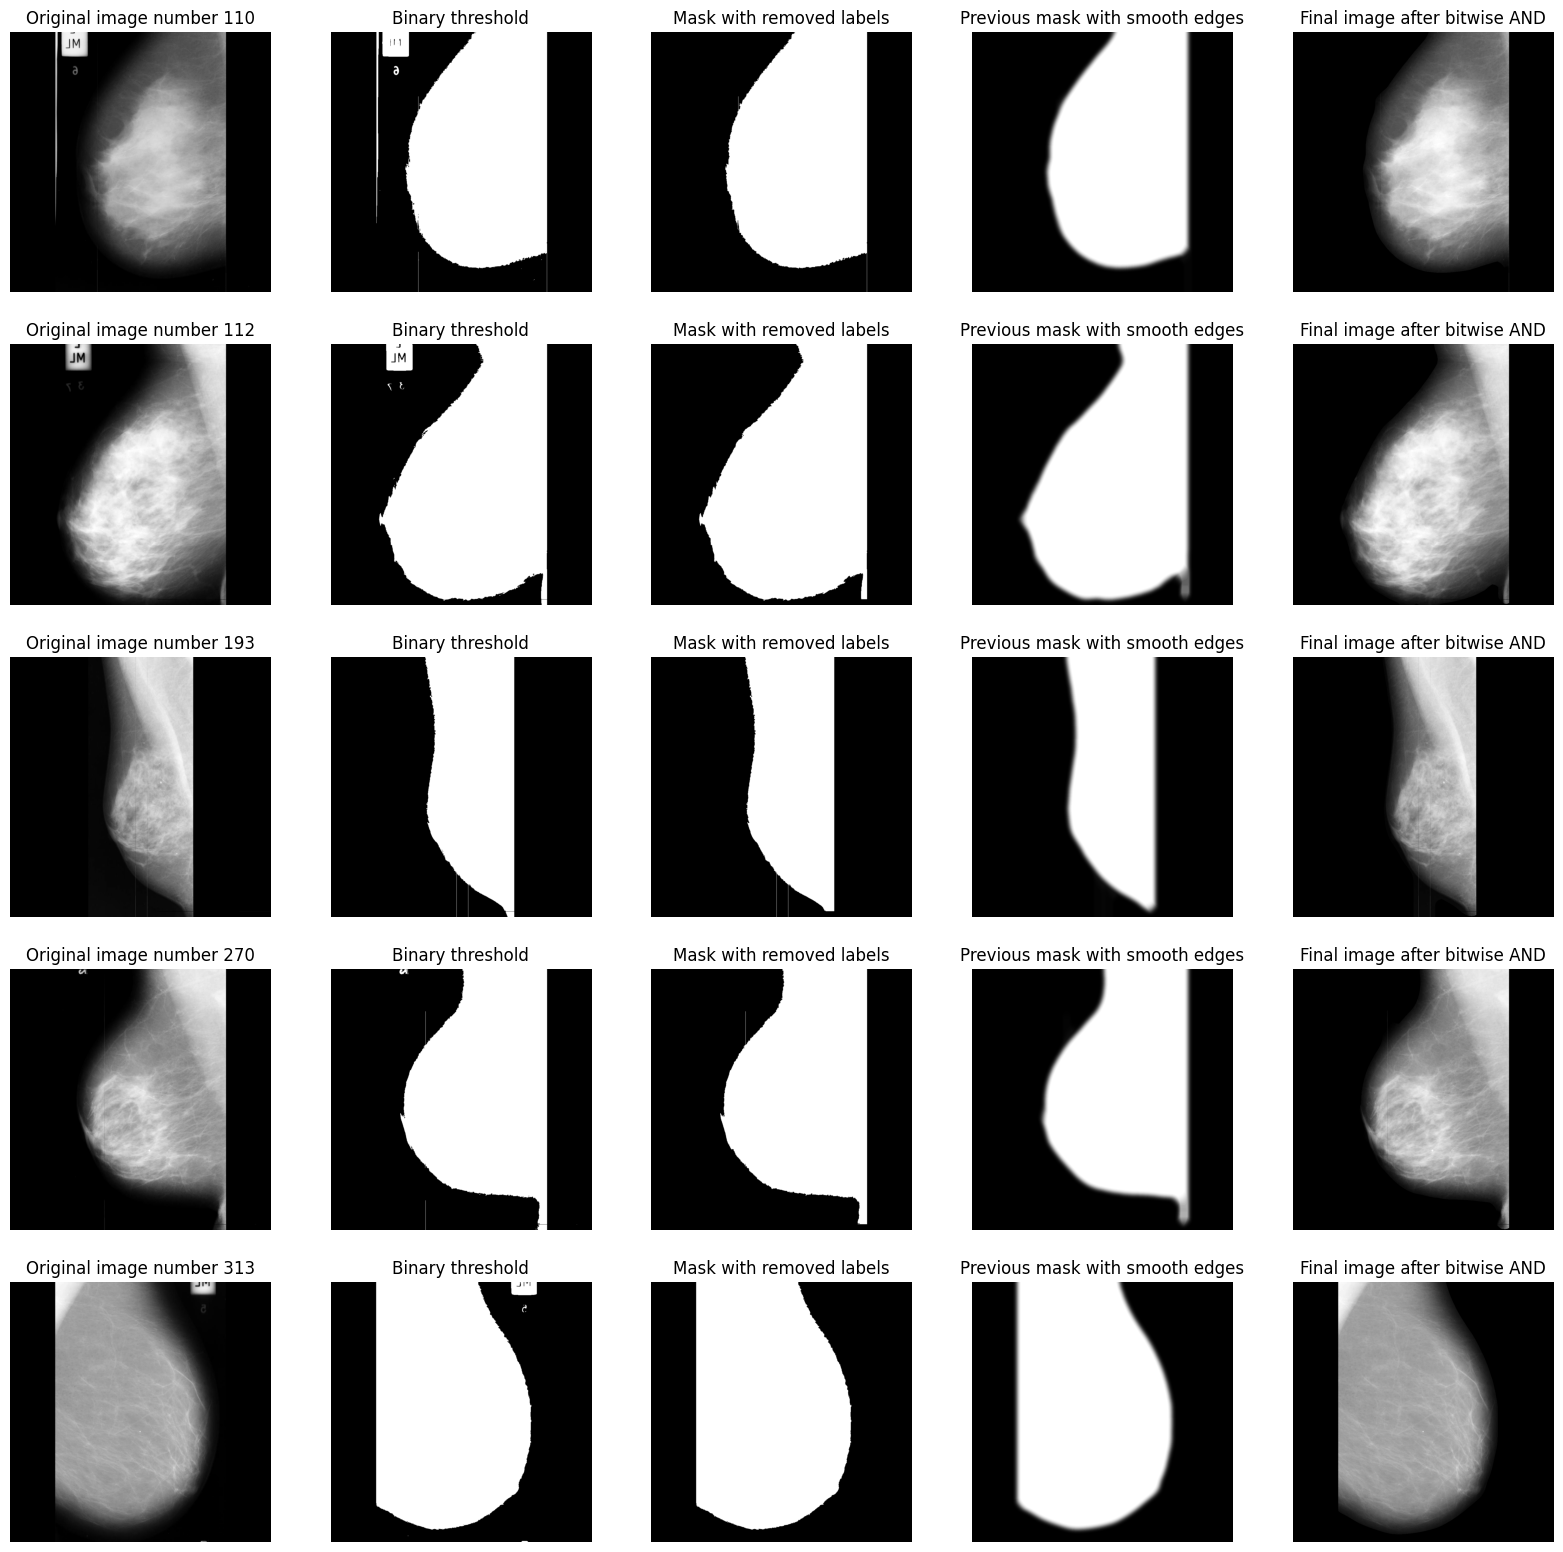

In [22]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 20), dpi = 100);
    
currRow = 0
finalDir = driveURL + '/'  'all-mias-no-label'

for i in range(total_images):

    # Read the image
    img = cv2.imread(img_add[i], cv2.IMREAD_GRAYSCALE)

    j = 0

    rows, cols = img.shape

    # Crop the image using experimental values
    img = img[15:rows - 15, 15:cols - 15]

    # Display the image
    if i in rand_image_idx:
        plot(axes[currRow][j], f'Original image number {i + 1}', img)
        j += 1

    # Apply binary threshold function
    # Source image, threshold value, max value assigned to pixels which cross the threshold, type of thresholding
    # Pixel values lie between 0 to 255
    # Thresh = 30 is an experimental value
    threshold, outputImg = cv2.threshold(src = img, thresh = 30, maxval = 255, type = cv2.THRESH_BINARY)

    # Display the image
    if i in rand_image_idx:
        plot(axes[currRow][j], 'Binary threshold', outputImg)
        j += 1

    # Get all contours
    # Mode refers to the type of contours that will be retrieved, cv2.RETR_EXTERNAL retrives only the extreme outer contours
    # Method refers to method in which we want to store the contours, cv2.CHAIN_APPROX_SIMPLE will compress segments
    contours, hierarchy = cv2.findContours(outputImg, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with maximum area
    maxContour = 0 
    maxContourData = -1

    for contour in range(len(contours)):
        # Calculate and compare area
        contourSize = cv2.contourArea(contours[contour])
        if contourSize > maxContour:
            maxContour = contourSize
            maxContourData = contour

    # Generate 2 black images
    mask = np.zeros_like(outputImg)

    # Draw the mask
    cv2.drawContours(mask, contours, maxContourData, color = (255, 255, 255), thickness = -1)

    # Display image
    if i in rand_image_idx:
        plot(axes[currRow][j], 'Mask with removed labels', mask)
        j += 1

    # Gaussian blur
    mask = cv2.GaussianBlur(mask, (49, 49), 0)

    # Median blur
    mask = cv2.medianBlur(mask, 49)
    
    # Display image
    if i in rand_image_idx:
        plot(axes[currRow][j], 'Previous mask with smooth edges', mask)
        j += 1
    
    # Bitwise AND of original image using mask
    finalImg = cv2.bitwise_and(img, img, mask = mask)

    # Display image
    if i in rand_image_idx:
        plot(axes[currRow][j], 'Final image after bitwise AND', finalImg)
        currRow += 1
    
    # Save the image
    cv2.imwrite(finalDir + '/' + img_name[i], finalImg)